# VAEs in Keras plus my additional notes

In [1]:
import keras
keras.__version__

import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow as tf
import matplotlib.pyplot as plt

tfd = tfp.distributions

from keras import backend as K
from keras import layers
from keras.models import Model
import numpy as np
K.clear_session()

Using TensorFlow backend.


In [2]:
img_shape = (28, 28, 1)
batch_size = 32
latent_dim = 3

input_img = keras.Input(shape=img_shape)
encoder_input = input_img

x = layers.Conv2D(32, 3, padding='same', 
                  activation='relu')(input_img)
x = layers.Conv2D(64, 3, padding='same',
                 activation='relu',
                 strides=(2,2))(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
x = layers.Conv2D(64, 3,
                  padding='same', activation='relu')(x)
shape_before_flattening = K.int_shape(x)
# int_shape returns a tuple of ints or Nones

x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)



Instructions for updating:
Colocations handled automatically by placer.


In [3]:
z_mean = layers.Dense(latent_dim, activation=None)(x)
def normalize(args):
    z_mean = args
    return tf.nn.l2_normalize(z_mean, axis=-1)

z_mu = layers.Lambda(normalize)(z_mean)
encoder = Model(encoder_input, z_mu)
z_log_var = layers.Dense(latent_dim)(x)
z_log_concentration = layers.Dense(1)(x)

In [4]:
from hyperspherical_vae.distributions import VonMisesFisher as VMS

vmf = tfd.VonMisesFisher
vmf_2 = VMS

Instructions for updating:
The TensorFlow Distributions library has moved to TensorFlow Probability (https://github.com/tensorflow/probability). You should update all references to use `tfp.distributions` instead of `tf.distributions`.


In [5]:
def sampling(args):
    z_mu, z_log_concentration = args
    vmf_current = vmf(mean_direction=z_mu, 
                      concentration=K.reshape(K.exp(z_log_concentration), (-1,)))
    
    return vmf_current.sample()#sample_shape=z_mu.shape)

### Note: An example of Lambda layer

In [6]:
z = layers.Lambda(sampling)([z_mu, z_log_concentration])
# the syntax is as follows:
# (sampling) is  the function apllied to the layers
# [z_mean, z_log_var] is the list of input layers

In [7]:
decoder_input = layers.Input(K.int_shape(z)[1:])
# [1:] means that we skip the batch size, witch we do not
# inclute in Input layer

# Upsample to the correct number of units
w = layers.Dense(np.prod(shape_before_flattening[1:]),
                activation='relu')(decoder_input)

# Reshape into an image of the same shape as before our last `Flatten` 
w = layers.Reshape(shape_before_flattening[1:])(w)

# Deconvolution
w = layers.Conv2DTranspose(32, 3,
                          padding='same',
                          activation='relu',
                          strides=(2,2))(w)
w = layers.Conv2DTranspose(1, 3,
                          padding='same', activation='sigmoid')(w)

decoder = Model(decoder_input, w)
z_decoded = decoder(z)



### Note: Custom Keras layer example

In [8]:
class CustomVariationalLayer(keras.layers.Layer):
    
    def vae_loss(self, x, z_decoded):
        x = K.flatten(x)
        z_decoded = K.flatten(z_decoded)
        # now the tensor shape is (batch_size, flattened)
        xent_loss = K.mean(keras.metrics.binary_crossentropy(x, z_decoded))
        #js_loss = None
        #w_loss = 5e-4 * K.mean(K.square(z_mean) + 1 +  K.exp(z_log_var) - 2 * K.sqrt(K.exp(z_log_var)))
        #kl_loss = -5e-4 * K.mean(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
        kl_vmf_loss = K.mean(K.maximum(K.exp(z_log_concentration), 10))
        return xent_loss + 0.01*kl_vmf_loss
        #return kl_vmf_loss
    def call(self, inputs):
        x = inputs[0]
        z_decoded = inputs[1]
        loss = self.vae_loss(x, z_decoded)
        self.add_loss(loss, inputs=inputs)
        return x                      

In [9]:
y = CustomVariationalLayer()([input_img, z_decoded])

In [10]:
from keras.datasets import mnist

vae = Model(input_img, y)
vae.compile(optimizer='rmsprop', loss=None)
vae.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 32)   320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 64)   18496       conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_3 (Conv2D)               (None, 14, 14, 64)   36928       conv2d_2[0][0]                   
__________________________________________________________________________________________________
conv2d_4 (

In [22]:
# Train the VAE on MNIST digits
(x_train, _), (x_test, y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_train = x_train.reshape(x_train.shape + (1,))
x_test = x_test.astype('float32') / 255.
x_test = x_test.reshape(x_test.shape + (1,))

vae.fit(x=x_train, y=None,
        shuffle=True,
        epochs=10,
        batch_size=batch_size,
        validation_data=(x_test, None))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 68s 1ms/step - loss: 0.3224 - val_loss: 0.3206
Epoch 2/10
40128/60000 [===================>..........] - ETA: 21s - loss: 0.3221

KeyboardInterrupt: 

## Plotting the generated samples

In [23]:
z_sample = tfd.VonMisesFisher(mean_direction=[1., 0., 0.], 
                              concentration=0.).sample(sample_shape=(100))
sess = K.get_session()
z_sample_ = sess.run(z_sample)
generated = decoder.predict(z_sample_, batch_size=batch_size)

<IPython.core.display.Javascript object>


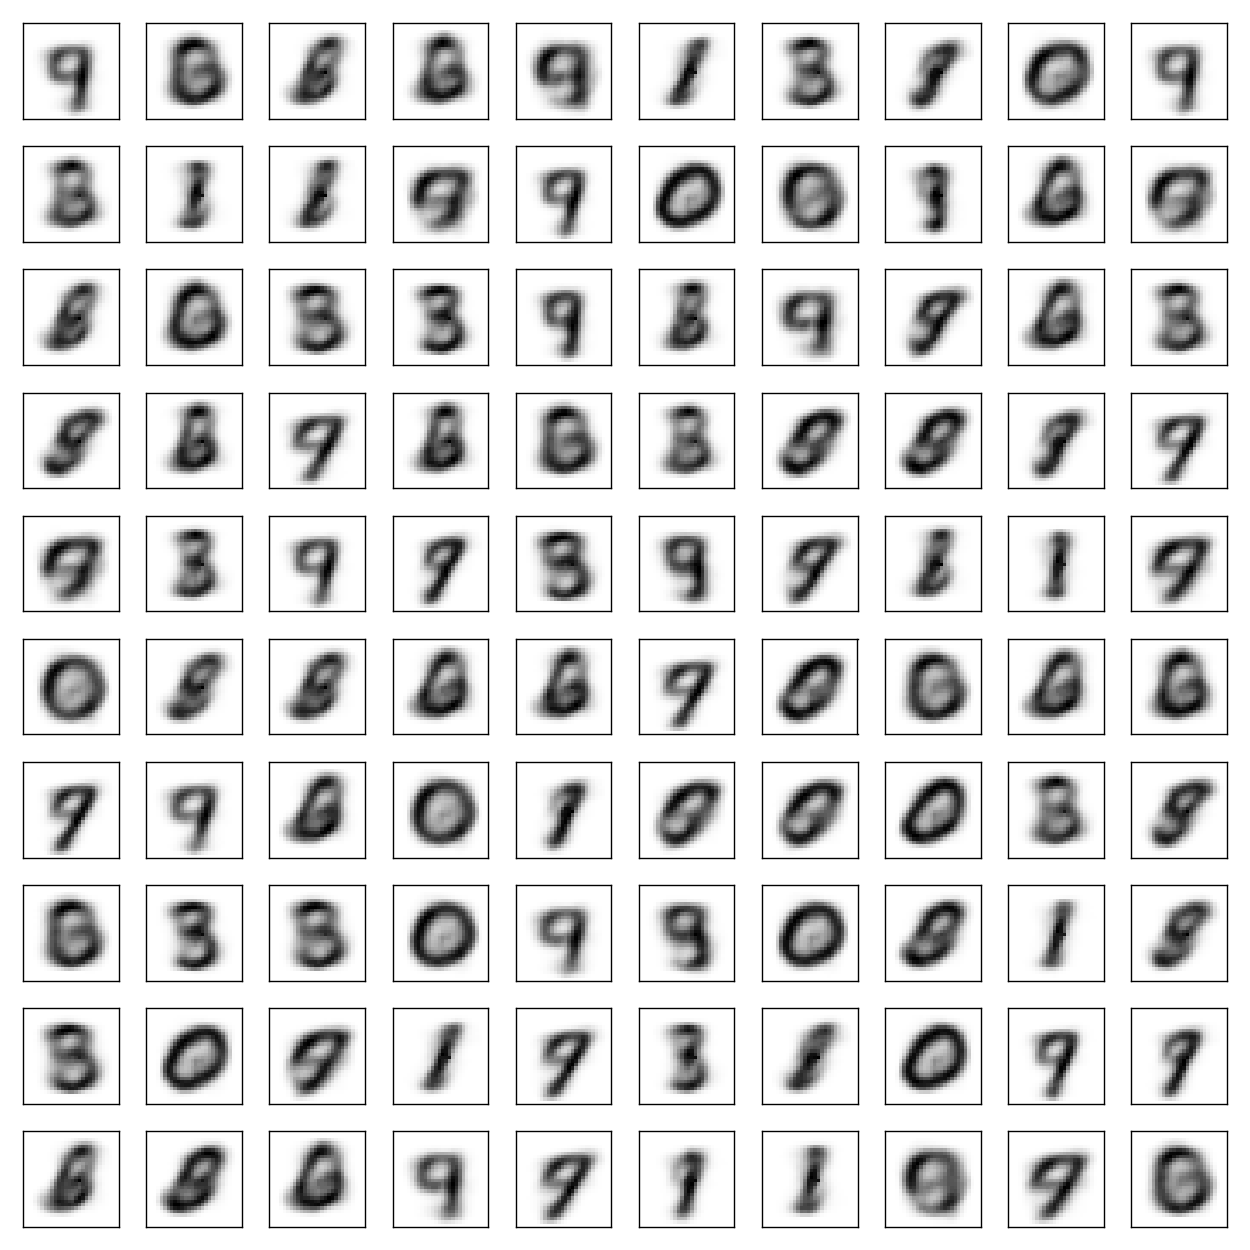

In [24]:
fig, axes = plt.subplots(10, 10, figsize=(10,10))
for j in range(10*10):
    axes[j//10, j%10].imshow(generated[j,:,:,0], cmap='binary')
    axes[j//10, j%10].set_xticks([])
    axes[j//10, j%10].set_yticks([])
plt.tight_layout()
plt.show()

## Plotting latent space representation

In [17]:
num_samples =5000
samples = x_test[:num_samples]
codes = encoder.predict(samples)
labels = y_test[:num_samples]

In [18]:
labels.shape

(5000,)

In [19]:
codes[:10]

array([[ 0.4542465 ,  0.5381075 ,  0.7100004 ],
       [-0.09823745, -0.97733086, -0.1875467 ],
       [-0.43010524, -0.31308275,  0.84675175],
       [-0.11699229, -0.14572437, -0.9823835 ],
       [ 0.98828393,  0.14149845,  0.05721243],
       [-0.4124521 , -0.30759367,  0.8574785 ],
       [ 0.8157107 ,  0.30008426,  0.49453554],
       [ 0.7494661 , -0.570315  ,  0.33621618],
       [ 0.40290156,  0.8147057 , -0.41704318],
       [ 0.22331573,  0.9167178 ,  0.33129835]], dtype=float32)

In [20]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
#%matplotlib notebook


    
colors = ['red', 'orange', 'green', 'yellow', 'plum', 
        'navy', 'salmon', 'skyblue', 'darkred', 'aqua']

data = []
group_names = []
for j in np.unique(labels):
    data.append(codes[labels.reshape(-1)==j])
    group_names.append(j)

<IPython.core.display.Javascript object>


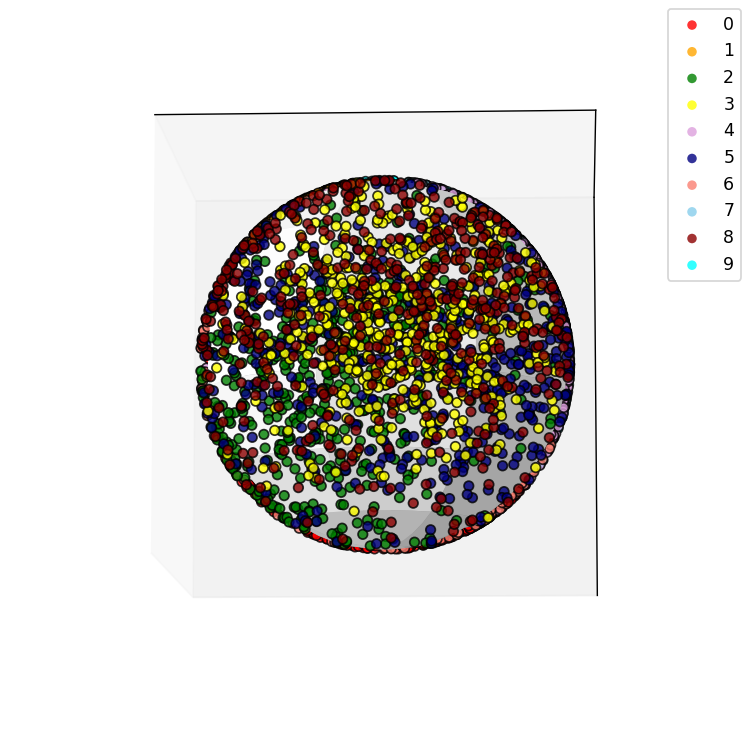

In [21]:
%matplotlib notebook
fig = plt.figure(figsize=(6,6))
ax = Axes3D(fig)
#ax.view_init(30, angle)
for datapart, group_name, color in zip (data, group_names, colors):
    x, y, z = datapart[:,0], datapart[:,1], datapart[:,2]
    ax.scatter(x, y, z, alpha=0.8, edgecolors='none', s=30, label=group_name, c=color)
    #ax.scatter(codes[:,0], codes[:,1], codes[:,2], c=labels, label=labels)

u = np.linspace(0, np.pi, 30)
v = np.linspace(0, 2 * np.pi, 30)

x = np.outer(np.sin(u), np.sin(v))
y = np.outer(np.sin(u), np.cos(v))
z = np.outer(np.cos(u), np.ones_like(v))

#ax.plot_wireframe(x, y, z, rstride=2, cstride=2, alpha=0.2)

plt.legend()
ax.set_xticks([])
ax.set_yticks([])
ax.set_zticks([])

ax.plot_surface(x, y, z,  rstride=4, cstride=4, color='white', linewidth=0, alpha=1.)
plt.show()